In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os

# Import TDA pipeline requirements
import gudhi as gd
import json

from KDEpy import FFTKDE

from scipy import ndimage
import persim

In [2]:
nuclei_mask_cutoff = 2
pows2 = 2**np.arange(20) + 1

nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
wsrc = '../cell_dams/'
ksrc = '../kde/'
sample = 'D2'

ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
weight = np.load(ksrc + sample + '_border_weights.npy', allow_pickle=True)

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

focus = pd.read_csv('../data/D2_data/scattersutton.csv')
focus = focus[ focus['Bact'] == 'Infected' ]
print(focus.shape)

metafocus = np.zeros( (len(focus),1+metacell.shape[1]) )
for i in range(len(metafocus)):
    foo = metacell[metacell['orig_cellID'] == focus.iloc[i,0]].iloc[0,:]
    metafocus[i,0] = foo.name
    metafocus[i,1:] = foo.values

metafocus = metafocus.astype(int)

(968, 5)


In [14]:
cell_focus = pd.DataFrame()
cell_focus['original_ID'] = focus['Cell.ID..']
cell_focus['ndimage_ID'] = metafocus[:,0]
cell_focus.to_csv('../data/D2_data/infected_cells_ids.csv', index=False)

In [4]:
gfoc = ['GLYMA_17G195900', 'GLYMA_01G164600', 'GLYMA_15G210100', 'GLYMA_05G216000', 
        'GLYMA_17G185800', 'GLYMA_05G203100', 'GLYMA_15G210100', 'GLYMA_05G092200']
gid = np.zeros(len(gfoc), dtype=int)
for i in range(len(gid)):
    gid[i] = np.nonzero(transcriptomes == gfoc[i])[0][0]

gene_focus = pd.DataFrame()
gene_focus['original_name'] = gfoc
gene_focus['gene_ID'] = gid
gene_focus.to_csv('../data/D2_data/genes_to_focus.csv', index=False)

In [6]:
TT = ['GLYMA_05G092200','GLYMA_17G195900']
tidxs = np.array([np.argwhere(transcriptomes == TT[i])[0][0] for i in range(len(TT))])
transfocus = transcell.loc[tidxs, metacell.loc[metafocus[:,0], 'ndimage_cellID'].values.astype(str)]

zvals = np.empty((0), dtype=float)
for j in range(len(tidxs)):
    zvals = np.hstack((zvals, (tlocs.iloc[ tcumsum[tidxs[j]]:tcumsum[tidxs[j] + 1] , -1].values)))
zvmin,zvmax = np.quantile(zvals, [0.05,0.95])
zbins = np.linspace(zvmin, zvmax, 16)

In [7]:
level = 'sub'
normtype='gene'

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep
dst = '../animation/' + sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

if   normtype == 'both':
    ratios = transfocus.values/np.sum(transfocus.values, axis=None)
elif normtype == 'cell':
    ratios = transfocus.values/np.sum(transfocus.values, axis=0)
elif normtype == 'gene':
    ratios = transfocus.values/np.sum(transfocus.values, axis=1).reshape(-1,1)

vmaxes = maxkde[metafocus[:,0]][:, tidxs].T
print(vmaxes.shape, ratios.shape)
vmaxes *= ratios

maxx = np.max(vmaxes)
rescale  = 256/maxx

print('Max ratio:\t', 100*np.max(ratios), '%')
transfocus

NameError: name 'maxkde' is not defined

In [ ]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wall[tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%50, axis=0)]

In [5]:
tt = 0
cidxs = 300
cidx = int(metafocus[cidxs,0])
tidx = tidxs[tt]

coords = translocs[tidx].values.T
cmask = label[ coords[1], coords[0] ] == cidx + 1
ccoords = coords[:, cmask ].copy()
print(cidx, ccoords.shape, sep='\t')
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

2014	(3, 452)


In [6]:
maxdims = ( cell.shape[1], cell.shape[0], np.max(tlocs['Z']+stepsize) )
print('Maxdims:\t',maxdims)
axes, grid, gmask = kde_grid_generator(stepsize=stepsize, maxdims=maxdims, pows2 = pows2, pad=1.5)
grid[:, :2] = grid[:, :2] + np.array([ss[1].start, ss[0].start])

Maxdims:	 (381, 306, 64)


In [7]:
w = weight[tcumsum[tidx]:tcumsum[tidx+1]][cmask]
wmax = np.max(w)

kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T, w).evaluate(grid)
kde = kde[gmask]/(np.sum(kde[gmask])*(stepsize**ndims))

cgrid = grid[gmask].copy()
cgrid[:,:2] = grid[gmask][:,:2] - np.array([ss[1].start, ss[0].start])
kde[ cell[cgrid[:,1],cgrid[:,0]] != 2 ] = 0
kde = kde/(np.sum(kde)*(stepsize**ndims))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(kde)*(stepsize**ndims), 'KDE.shape:\t', kde.shape, '\nMax KDE:\t', np.max(kde))

rkde = kde.copy()*ratios[tt, cidxs]
print(rkde.max(), vmaxes[tt, cidxs], np.max(vmaxes[:, cidxs]))

1.0 KDE.shape:	 (22, 102, 127) 
Max KDE:	 4.411338723603853e-06
4.163847721635993e-09 -0.0009438966224371745 -0.0006323722995121699


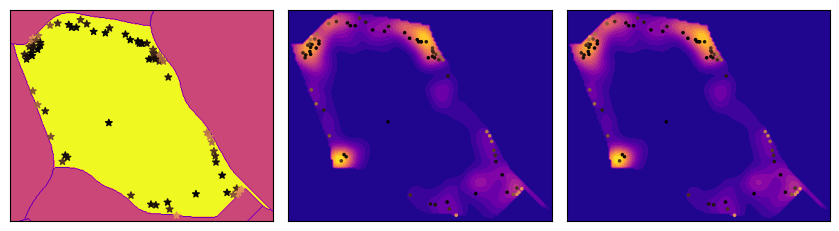

In [25]:
fs = 18
vmax = [None, np.max(kde), np.max(vmaxes[:, cidxs])]

zlevel = kde.shape[0]//2-2

fig, ax = plt.subplots(1,3,figsize=(8.5,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax); j = 0

zmask = (ccoords[2] >= axes[2][zlevel]) & (ccoords[2] < axes[2][zlevel+1])
ax[j].imshow(cell, cmap='plasma', origin='lower', extent=extent); j+=1
for density in [kde, rkde]:
    ax[j].contourf(axes[0]+ss[1].start, axes[1]+ss[0].start, density[zlevel,:,:], 16, cmap='plasma', vmin=0, zorder=1, vmax=vmax[j])
    j += 1
    
if np.sum(zmask) > 0:
    ax[0].scatter(ccoords[0][zmask], ccoords[1][zmask], c=w[zmask], cmap='copper', marker='*', 
                  zorder=3, s=25, alpha=1, vmin=1, vmax=wmax);
    for i in range(1,len(ax)):
        ax[i].scatter(ccoords[0][zmask], ccoords[1][zmask], c=w[zmask],
                     cmap='copper', marker='o', s=2.5, alpha=1, zorder=3, vmin=1, vmax=wmax)
    
for a in ax.ravel():
    a.set_aspect('equal')
    a.margins(0)
    a.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

fig.tight_layout();

In [8]:
pers = gd.CubicalComplex(top_dimensional_cells = get_top_cells(kde, level) ).persistence(homology_coeff_field=2, min_persistence=1e-15)
pers = pers2numpy(pers)
pers

array([[1.00000000e+00, 1.57982455e-06, 1.64151237e-06],
       [1.00000000e+00, 1.05515360e-06, 1.11018814e-06],
       [1.00000000e+00, 1.36275819e-06, 1.39761500e-06],
       [1.00000000e+00, 1.23704226e-06, 1.25746393e-06],
       [1.00000000e+00, 1.52322352e-06, 1.54057288e-06],
       [1.00000000e+00, 1.59717877e-06, 1.60305280e-06],
       [1.00000000e+00, 1.39879462e-06, 1.40300641e-06],
       [1.00000000e+00, 1.25113466e-06, 1.25419308e-06],
       [1.00000000e+00, 1.23830811e-06, 1.24037003e-06],
       [1.00000000e+00, 1.36558490e-06, 1.36755680e-06],
       [1.00000000e+00, 1.57387975e-06, 1.57548940e-06],
       [1.00000000e+00, 1.64011617e-06, 1.64139704e-06],
       [1.00000000e+00, 1.53288199e-06, 1.53390412e-06],
       [1.00000000e+00, 1.33284306e-06, 1.33386010e-06],
       [1.00000000e+00, 1.58082642e-06, 1.58158662e-06],
       [1.00000000e+00, 1.64098499e-06, 1.64151237e-06],
       [1.00000000e+00, 1.63768223e-06, 1.63788603e-06],
       [1.00000000e+00, 1.64130

In [26]:
filename = '{}{}/{}_-_{}level_p{}_s{}_bw{}_c{:06d}.json'.format(gsrc,transcriptomes[tidx],transcriptomes[tidx],level,PP,stepsize,bw,cidx)
print(filename)
with open(filename) as f:
    diag = [tuple(x) for x in json.load(f)]
diag = pers2numpy(diag)
print('Difference:\t',np.sum(np.abs(pers[np.all(pers < np.inf, axis=1), 1:] - diag[np.all(diag < np.inf, axis=1), 1:])))

../suplevel/D2/GLYMA_05G092200/GLYMA_05G092200_-_suplevel_p6_s3_bw10_c002014.json


ValueError: operands could not be broadcast together with shapes (64,2) (19,2) 

In [13]:
sers = pers.copy()
sers[:,1:] = sers[:,1:]*ratios[tt, cidxs]

rers = gd.CubicalComplex(top_dimensional_cells = get_top_cells(rkde, level)).persistence(homology_coeff_field=2, min_persistence=1e-15)
rers = pers2numpy(rers)
print(rers.shape, sers.shape)
rers

(20, 3) (20, 3)


array([[1.00000000e+00, 3.08376954e-09, 3.18518890e-09],
       [1.00000000e+00, 3.18050471e-09, 3.18372676e-09],
       [1.00000000e+00, 4.16361600e-09, 4.16384772e-09],
       [1.00000000e+00, 4.16381082e-09, 4.16384772e-09],
       [1.00000000e+00, 4.16363326e-09, 4.16366443e-09],
       [1.00000000e+00, 4.16367661e-09, 4.16370356e-09],
       [1.00000000e+00, 4.16382606e-09, 4.16383344e-09],
       [0.00000000e+00, 0.00000000e+00,            inf],
       [0.00000000e+00, 4.30963353e-10, 3.62404582e-09],
       [0.00000000e+00, 6.36435877e-10, 3.30612534e-09],
       [0.00000000e+00, 2.42456766e-09, 3.86304742e-09],
       [0.00000000e+00, 3.18510123e-09, 3.72696837e-09],
       [0.00000000e+00, 2.52421120e-09, 2.97278257e-09],
       [0.00000000e+00, 1.64226150e-09, 2.08671807e-09],
       [0.00000000e+00, 3.14631441e-09, 3.52783964e-09],
       [0.00000000e+00, 3.21977769e-09, 3.33896498e-09],
       [0.00000000e+00, 4.02825438e-09, 4.14405153e-09],
       [0.00000000e+00, 3.18002

In [15]:
print('Difference:\t',np.sum(np.abs(rers[np.all(rers < np.inf, axis=1), 1:] - sers[np.all(sers < np.inf, axis=1), 1:])))

Difference:	 5.893661864440322e-24


In [27]:
rkde = np.round(kde.copy()*ratios[tt, cidxs]*rescale).astype(np.uint8)

sers = diag.copy()
sers[:,1:] *= rescale*ratios[tt, cidxs]
sers = sers[np.all(sers < np.inf, axis=1) ]
sers = sers[sers[:,2] - sers[:,1] > 0.5]
sers = sers.astype(rkde.dtype)
mval, Mval = np.min(sers[:,1:]), np.max(sers[:,1:])
print(mval, Mval, rkde.max())
sers

23 225 227


array([[  1, 168, 173],
       [  0,  23, 197],
       [  0,  34, 180],
       [  0, 132, 210],
       [  0, 173, 203],
       [  0, 137, 162],
       [  0,  89, 113],
       [  0, 171, 192],
       [  0, 175, 182],
       [  0, 219, 225],
       [  0, 173, 176],
       [  0, 191, 194],
       [  0, 196, 199]], dtype=uint8)

In [28]:
buf = 5
#vmask = (rkde > mval - buf) & (rkde < Mval + buf)
vmask = rkde > 0
voxels = np.asarray(np.nonzero( vmask )).T

anim = pd.DataFrame(voxels, columns=['Z', 'Y', 'X'])
anim['V'] = get_top_cells(rkde,level)[vmask]
print(len(anim),'\nKeep only', np.round(100*len(anim)/rkde.size, 1), '% of voxels')

89640 
Keep only 31.5 % of voxels


In [31]:
adst = dst + '{}_{}level_{}_c{}'.format(transcriptomes[tidxs[tt]], level, normtype, cidx) + os.sep
if not os.path.isdir(adst):
    os.mkdir(adst)

filename = adst + 'coords_kde.csv'
print(filename)
anim.to_csv(filename, index=False)

filename = adst + 'persistence_diagram.csv'
print(filename)
pd.DataFrame(sers, columns=['H', 'b', 'd']).to_csv(filename, index=False)

../animation/D2/GLYMA_05G092200_suplevel_gene_c2014/coords_kde.csv
../animation/D2/GLYMA_05G092200_suplevel_gene_c2014/persistence_diagram.csv


# Verify bottleneck distance is a distance

In [72]:
tidx = tidxs[0]

rlist = list(range(800,850))
filename = [ '{}{}/{}_-_sublevel_p{}_s{}_bw{}_c{:06d}.json'.format(gsrc,transcriptomes[tidx],transcriptomes[tidx],PP,stepsize,bw,cidx) for cidx in rlist]
diags = get_diagrams(filename, 3, remove_inf=True)


maxx = 0
numpairs = 0
argmaxx = 0

for i in range(len(diags)):
    for k in range(len(diags[i])):
        diags[i][k] *= ratios[0, rlist[i]]
        numpairs += len(diags[i][k])
    if maxx < np.max(diags[i][-1]):
        maxx = np.max(diags[i][-1])
        argmaxx = i

print('Initial number of life-birth pairs\t:', numpairs)

rescale = 256/maxx
maxlife = np.zeros((len(diags), ndims))
for i in range(len(diags)):
    for k in range(len(diags[i])):
        diags[i][k] *= rescale
        if len(diags[i][k]) > 0:
            maxlife[i,k] = diags[i][k][0,1] - diags[i][k][0,0]

argmaxlife = np.argmax(maxlife, axis=1)

Initial number of life-birth pairs	: 3870


In [74]:
bottleneck = np.zeros((len(diags),len(diags)))

for i in range(bottleneck.shape[0] - 1):
    for j in range(i+1, bottleneck.shape[1]):
        dk = np.zeros(ndims)
        for k in range(len(dk)):
            if (len(diags[i][k]) > 0) | (len(diags[j][k]) > 0):
                dk[k] = persim.bottleneck(diags[i][k], diags[j][k], matching=False)
        bottleneck[i,j] = np.max(dk)
        bottleneck[j,i] = np.max(dk)

In [125]:
diags1 = [ [ diags[i][k].copy()  for k in range(ndims) ] for i in range(len(diags)) ]
minlife = 8

reduced = 0
numpairs = 0
for i in range(len(diags1)):
    for k in range(len(diags1[i])):
        diags1[i][k]  = np.atleast_2d(diags1[i][k][np.diff(diags1[i][k]).squeeze() > minlife, :].squeeze())
        diags1[i][k]  = np.atleast_2d(diags1[i][k][np.all(diags1[i][k] < np.inf, axis=1), :].squeeze())
        numpairs += len(diags1[i][k])
    
    k = argmaxlife[i]
    if (len(diags1[i][k]) == 0) & (len(diags[i][k]) > 0):
        reduced +=1
        diags1[i][k] = np.atleast_2d(diags[i][k][0])
        numpairs += 1
    
print('Post number of life-birth pairs\t:', numpairs)
print('Diagrams reduced:\t{} [{:.2f} %]'.format(reduced, reduced/len(diags1)*100))

Post number of life-birth pairs	: 134
Diagrams reduced:	10 [20.00 %]


In [126]:
bottleneck1 = np.zeros((len(diags1),len(diags1)))

for i in range(bottleneck1.shape[0] - 1):
    for j in range(i+1, bottleneck1.shape[1]):
        dk = np.zeros(ndims)
        for k in range(len(dk)):
            if (len(diags1[i][k]) > 0) | (len(diags1[j][k]) > 0):
                dk[k] = persim.bottleneck(diags1[i][k], diags1[j][k])
        bottleneck1[i,j] = np.max(dk)
        bottleneck1[j,i] = np.max(dk)

In [127]:
diff = np.abs(bottleneck1 - bottleneck)
print(diff.max())
pd.Series(diff.ravel()).describe()

3.325966202236481


count    2500.000000
mean        0.228811
std         0.597530
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.325966
dtype: float64

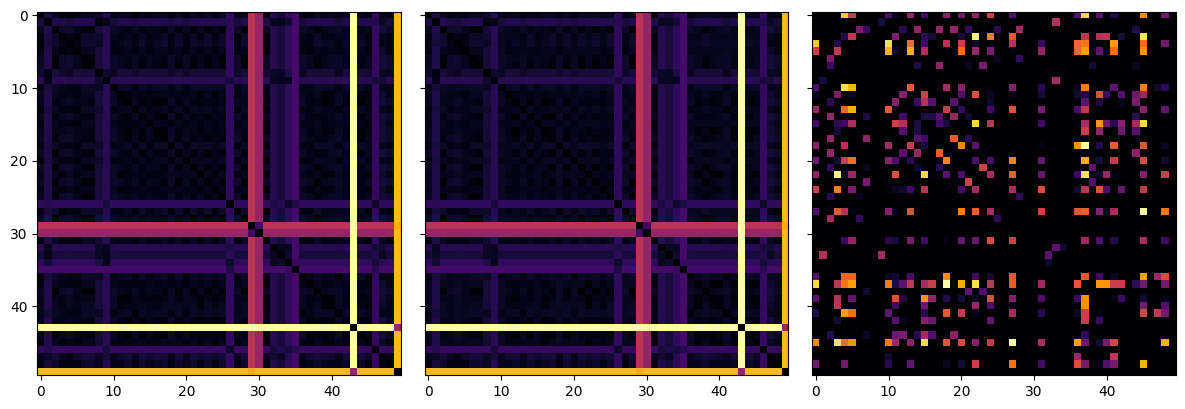

In [128]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
ax = ax.ravel()

for i,img in enumerate([bottleneck,bottleneck1, diff]):
    ax[i].imshow(img, cmap='inferno')
fig.tight_layout();

In [129]:
np.argsort(diff.ravel())[::-1][:20]

array([ 937, 1868, 1395, 2277, 1103,  172,  195, 2253, 1137, 1872,  210,
        504,  795, 2265, 1850,   37, 1115,  772,  200,    4])

In [130]:
foo = np.argmax(diff.ravel())
#foo = np.argmax(bottleneck)
argmax = (foo//len(diff), foo%len(diff))
print(argmax, diff[argmax])
print(bottleneck[argmax], bottleneck1[argmax], bottleneck[argmax]*rescale, bottleneck1[argmax]*rescale)

(18, 37) 3.325966202236481
4.72964004943511 8.055606251671591 17060284043.844822 29057376325.13994


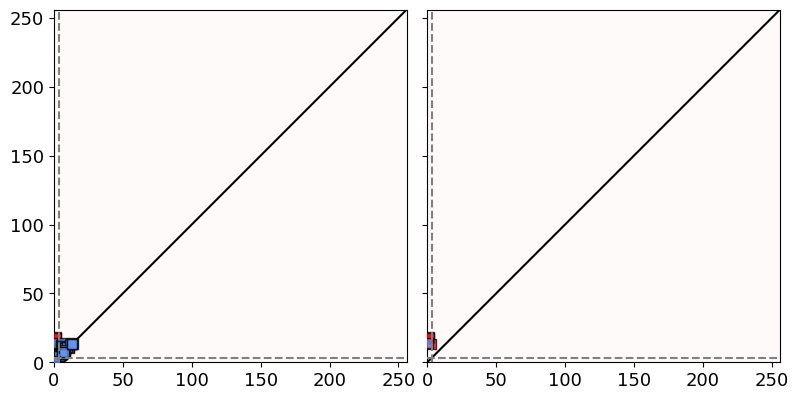

In [135]:
aux = maxx*rescale
fs = 16; marker = ['D', 'o', 's']; color = ['red','cornflowerblue','gold']
fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,dd in enumerate([ diags, diags1 ]):
    for j in range(2):
        for k in range(2,ndims):
            if len(dd[k]) > 0:
                ax[i].scatter(dd[argmax[j]][k][:,0], dd[argmax[j]][k][:,1], alpha=0.75, label='$H_{}$'.format(k), 
                              marker=marker[k], c=color[j], s=50, linewidth=1, edgecolor='k', zorder=k+4)
    
    ax[i].scatter([0, aux] , [0, aux] , alpha=0)
    ax[i].set_aspect('equal')
    #ax[i].legend(loc='lower right', fontsize=fs)
    ax[i].axline(xy1=(0,0), slope=1, c='k', zorder=1)
    ax[i].tick_params(labelsize=fs-3)
    ax[i].margins(0)
    ax[i].set_facecolor('snow')
    ax[i].axhline(diff[argmax], c='gray', ls='--', zorder=10)
    ax[i].axvline(diff[argmax], c='gray', ls='--', zorder=10)

fig.tight_layout()

In [110]:
diags1[argmax[1]][2]

array([[ 19.27103572, 256.        ],
       [101.83394849, 231.88327767]])

In [114]:
diags[argmax[1]][2] - diags1[argmax[1]][2]

array([[ 0.00000000e+00, -2.84217094e-14],
       [ 1.42108547e-14,  2.84217094e-14]])

In [113]:
persim.bottleneck(diags[argmax[1]][2], np.empty((0,2))) - persim.bottleneck(diags1[argmax[1]][2], diags1[argmax[0]][2])

-1.4210854715202004e-14

In [102]:
print(bottleneck[argmax], bottleneck1[argmax], diff[argmax])

118.3644821411451 118.36448214114512 1.4210854715202004e-14


In [133]:
dk = np.zeros(ndims)
dk1 = np.zeros(ndims)

i,j = argmax
for k in range(ndims):
    dk[k]  = gd.bottleneck_distance(diags[i][k], diags[j][k], e=None)
    dk1[k] = gd.bottleneck_distance(diags1[i][k], diags1[j][k], e=None)

print(dk)
print()
print(dk1)

[0.01552039 1.30570173 4.72964005]

[0.         0.         8.05560625]


In [134]:
dk = np.zeros(ndims)
dk1 = np.zeros(ndims)

i,j = argmax
for k in range(ndims):
    if (len(diags[i][k]) > 0) | (len(diags[j][k]) > 0):
        dk[k]  = persim.bottleneck(diags[i][k], diags[j][k])
    if (len(diags1[i][k]) > 0) | (len(diags1[j][k]) > 0):
        dk1[k] = persim.bottleneck(diags1[i][k], diags1[j][k])

print(dk)
print()
print(dk1)

[0.01552039 1.30570173 4.72964005]

[0.         0.         8.05560625]


1.4096526453046394

In [219]:
np.max(np.abs(diags[argmax[0]][2] - np.mean(diags[argmax[0]][2], axis=1).reshape(-1,1)), axis=1).astype(int)

array([50, 26, 20,  9,  1,  0,  0])

In [220]:
np.max(np.abs(diags[argmax[1]][2] - np.mean(diags[argmax[1]][2], axis=1).reshape(-1,1)), axis=1).astype(int)

array([69, 63,  8,  8])

In [221]:
import scipy.spatial.distance as distance

distance.cdist(diags[argmax[0]][2], diags[argmax[1]][2][:2], 'chebyshev').astype(int)

array([[ 44,  72],
       [ 83, 111],
       [101, 129],
       [114, 142],
       [138, 166],
       [143, 171],
       [123, 151]])

In [223]:
import persim

i,j = argmax
k = 2
print(persim.bottleneck(diags[i][k], diags[j][k], matching=False))
print(persim.bottleneck(diags1[i][k], diags1[j][k], matching=False))

63.9626563271497
63.96265632714971


In [261]:
morse = []
for i in range(len(pers)):
    for j in range(2):
        val = pers[i][1][j]
        if val < 300:
            morse.append(int(val))
morse.append(255)
morse = sorted(list(set(morse)))
print(len(morse), morse, sep='\n')

23
[0, 2, 4, 6, 7, 10, 13, 15, 16, 19, 24, 67, 69, 71, 72, 101, 110, 173, 189, 191, 203, 252, 255]


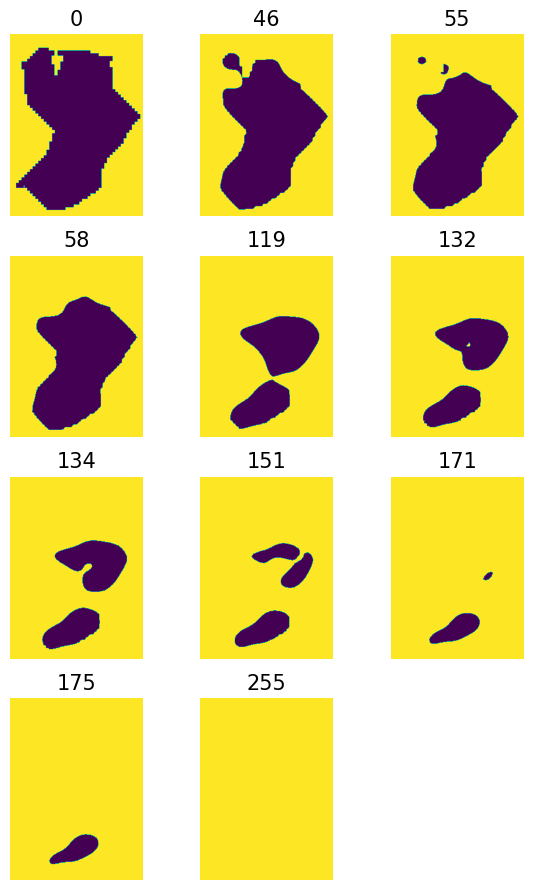

In [243]:
fig, ax = plt.subplots(4,3, figsize=(6,9), sharex=True, sharey=True)
ax = ax.ravel()

for i,val in enumerate(morse[:len(ax)]):
    ax[i].imshow(img <= val, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(val, fontsize=15)
    ax[i].axis('off');
    
if len(ax) - len(morse) > 0:
    for i in range(len(ax) - len(morse)):
        fig.delaxes(ax[-i-1])

filename = figdst + '{}_{}_{}_{}_sublevel_sets'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
plt.savefig(filename + '.jpg', format='jpg', dpi=250, bbox_inches='tight', pil_kwargs={'optimize':True})
fig.tight_layout();

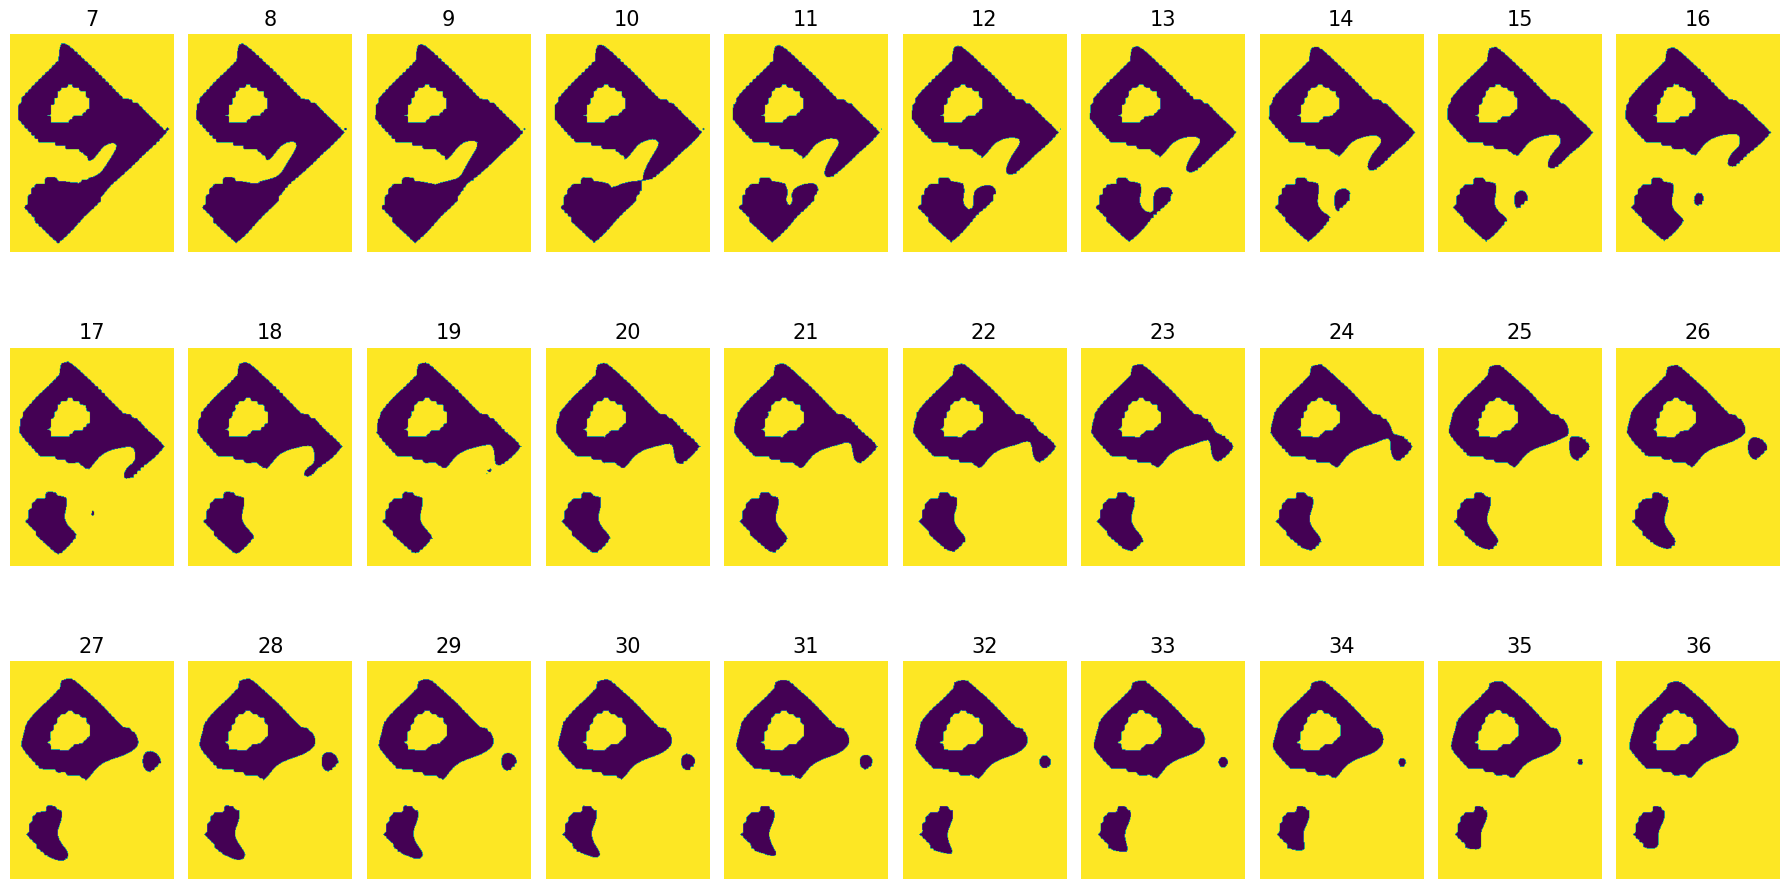

In [44]:
fig, ax = plt.subplots(3,10, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 7

for i in range(len(ax)):
    ax[i].imshow(img <= k + i, vmin=0, vmax=1, origin='lower');
    ax[i].set_title(k + i, fontsize=15)
    ax[i].axis('off');

fig.tight_layout();

In [23]:
maxv = img.max()
cc = gd.CubicalComplex(top_dimensional_cells = maxv-img)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1)
filename = sdst + transcriptomes[tidx] + '_' + jsname + '_' + selection + '_superlevel.json'
print(filename)
with open(filename, 'w') as f:
    json.dump(pers,f)
pers

../gd_trans/D2/GLYMA_06G090100/GLYMA_06G090100_c2499_b15_all_superlevel.json


[(0, (0.0, inf)),
 (0, (49.0, 135.0)),
 (0, (50.0, 135.0)),
 (0, (62.0, 134.0)),
 (0, (71.0, 120.0)),
 (0, (85.0, 129.0)),
 (0, (84.0, 96.0)),
 (0, (32.0, 37.0))]

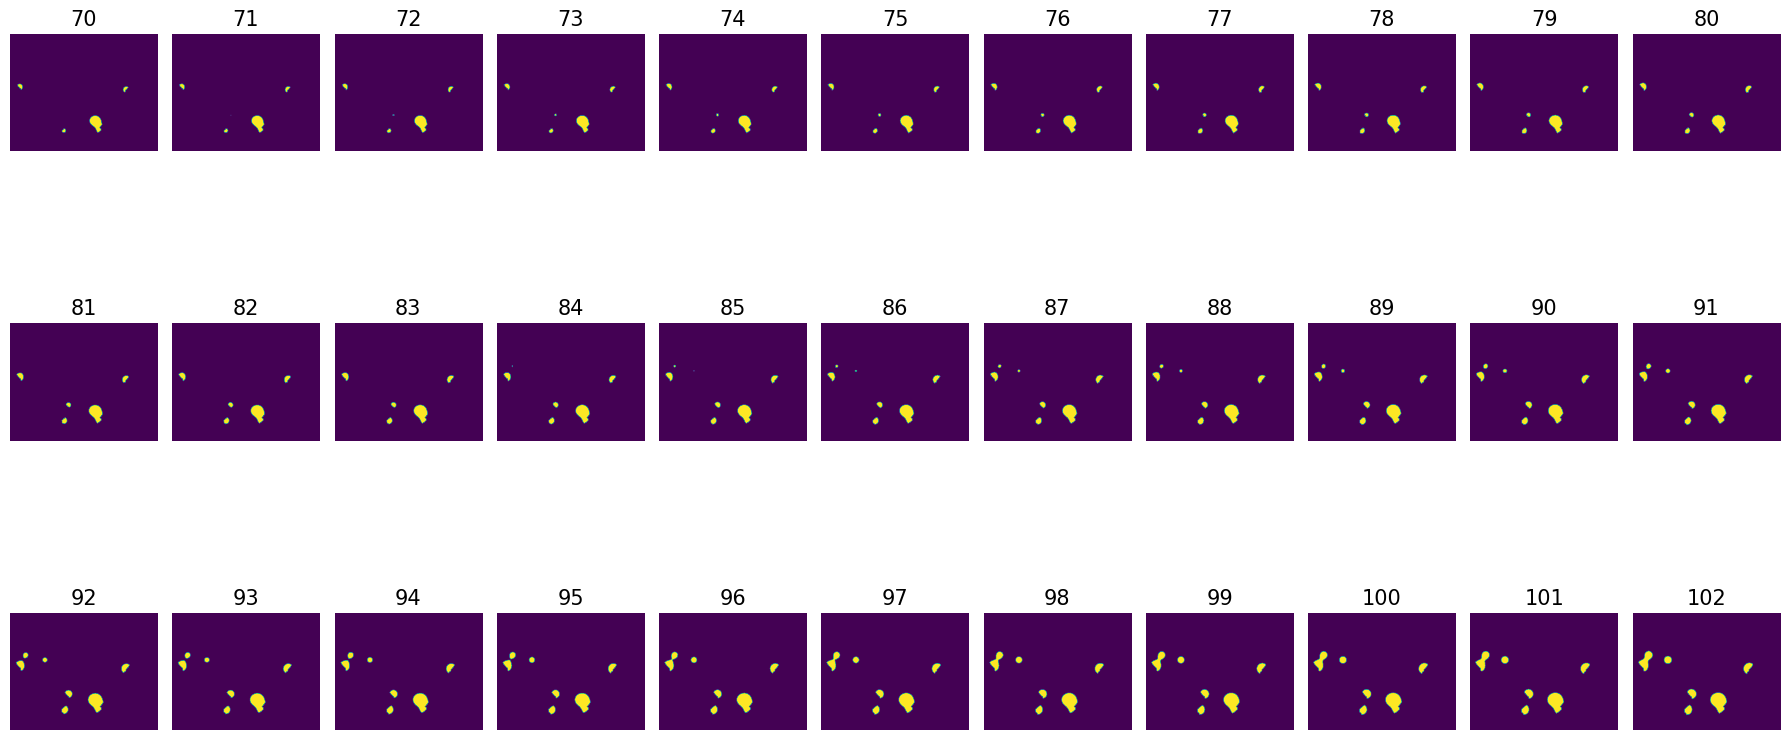

In [24]:
fig, ax = plt.subplots(3,11, figsize=(18,10), sharex=True, sharey=True)
ax = ax.ravel()
k = 70
bar = maxv - img 
for i in range(len(ax)):
    #j = len(ax) - 1 - i
    j = i
    ax[j].imshow(bar <= k + i, vmin=0, vmax=1, origin='lower');
    ax[j].set_title(k + i, fontsize=15)
    ax[j].axis('off');

fig.tight_layout();